<h1>LightGBM Models Training</h1>
<h3>WIDS 2024 Challenge ++</h3>
<h3>BMI 212 - Team DMMTS</h3>

In [51]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

<h4> Load the data</h4>

In [16]:
# Load the CSV dataset
df = pd.read_csv('../Data/train_test_tt.csv')

# Rename feature columns for better readability
df.rename(columns={'bmi': 'patient_bmi',
                   'region': 'patient_region',
                   'division': 'patient_division',
                   'side': 'patient_tumor_side',
                   'quadrant': 'patient_tumor_quadrant',
                   'metastatic_organ': 'patient_metastatic_organ',
                   'cleaned_metastatic_first_treatment': 'patient_metastatic_first_treatment',
                   'cleaned_metastatic_first_treatment_type': 'patient_metastatic_first_treatment_type',
                   'population': 'population_size',
                   'density': 'population_density',
                   'age_median': 'population_age_median',
                   'female': 'population_female_perc',
                   'married': 'population_married_perc',
                   'divorced': 'population_divorced_perc',
                   'never_married': 'population_never_married_perc',
                   'widowed': 'population_widowed_perc',
                   'family_size': 'population_family_size',
                   'family_dual_income': 'population_family_dual_income_perc',
                   'income_individual_median': 'population_income_individual_median',
                   'income_household_median': 'population_income_household_median',
                   'home_ownership': 'population_home_ownership_perc',
                   'home_value': 'population_home_value',
                   'rent_median': 'population_rent_median',
                   'rent_burden': 'population_rent_burden_perc',
                   'education_less_highschool': 'population_education_less_highschool_perc',
                   'education_highschool': 'population_education_highschool_perc',
                   'education_some_college': 'population_education_some_college_perc',
                   'education_bachelors': 'population_education_bachelors_perc',
                   'education_graduate': 'population_education_graduate_perc',
                   'education_college_or_above': 'population_education_college_or_above_perc',
                   'education_stem_degree': 'population_education_stem_degree_perc',
                   'unemployment_rate': 'population_unemployment_rate',
                   'self_employed': 'population_self_employed_perc',
                   'farmer': 'population_farmer_perc',
                   'race_white': 'population_race_white_perc',
                   'race_black': 'population_race_black_perc',
                   'race_asian': 'population_race_asian_perc',
                   'race_native': 'population_race_native_american_perc',
                   'race_pacific': 'population_race_pacific_islander_perc',
                   'race_other': 'population_race_other_perc',
                   'race_multiple': 'population_race_multiple_perc',
                   'hispanic': 'population_hispanic_perc',
                   'disabled': 'population_disabled_perc',
                   'poverty': 'population_poverty_perc',
                   'limited_english': 'population_limited_english_perc',
                   'commute_time': 'population_commute_time',
                   'health_uninsured': 'population_health_uninsured_perc',
                   'veteran': 'population_veteran_perc'
                   }, inplace=True)

<h4>Select the features to use</h4>

In [17]:
features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'patient_gender', 'patient_bmi',
            'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant',
            'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type',
            'population_size', 'population_density', 'population_age_median', 'population_female_perc',
            'population_married_perc', 'population_divorced_perc', 'population_never_married_perc',
            'population_widowed_perc', 'population_family_size', 'population_family_dual_income_perc',
            'population_income_individual_median', 'population_income_household_median', 'population_home_ownership_perc',
            'population_home_value', 'population_rent_median', 'population_rent_burden_perc',
            'population_education_less_highschool_perc', 'population_education_highschool_perc',
            'population_education_some_college_perc', 'population_education_bachelors_perc',
            'population_education_graduate_perc', 'population_education_college_or_above_perc',
            'population_education_stem_degree_perc', 'population_unemployment_rate', 'population_self_employed_perc',
            'population_farmer_perc', 'population_race_white_perc', 'population_race_black_perc',
            'population_race_asian_perc', 'population_race_native_american_perc', 'population_race_pacific_islander_perc',
            'population_race_other_perc', 'population_race_multiple_perc', 'population_hispanic_perc',
            'population_disabled_perc', 'population_poverty_perc', 'population_limited_english_perc',
            'population_commute_time', 'population_health_uninsured_perc', 'population_veteran_perc']

# Select only rows where allocated_set is train
df = df[df['allocated_set'] == 'train']

# Select the features to use
df = df[features + ['treatment_pd']]

<h4>Split into train/test 80/20</h4>

In [38]:
# Convert object features to categorical
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

# List of categorical features
categorical_features = list(df.select_dtypes(include='category').columns)

# Create dfs of features and target
X = df.drop('treatment_pd', axis=1)
y = df['treatment_pd']

# Split the data into train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

<h4>Prep LightGBM dataset</h4>

In [74]:
# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, feature_name='auto', categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a regression model
params = {
    'objective': ['regression', 'poisson', 'tweedie'],
    'metric': ['rmse'], 
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model = lgb.LGBMRegressor()

# Create the grid search
grid = GridSearchCV(model, params, cv=10, scoring='neg_root_mean_squared_error')

# Fit the model to the data
grid.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

GridSearchCV(cv=10, estimator=LGBMRegressor(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'learning_rate': [0.1], 'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61],
                         'objective': ['regression', 'poisson', 'tweedie'],
                         'verbose': [-1]},
             scoring='neg_root_mean_squared_error')

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'poisson', 'verbose': -1}
Best score: -152.69381732361634
RMSE: 151.31946772223716
Range of target variable: 0.0 1441.0
SD of target variable: 188.52425507695818


<Axes: >

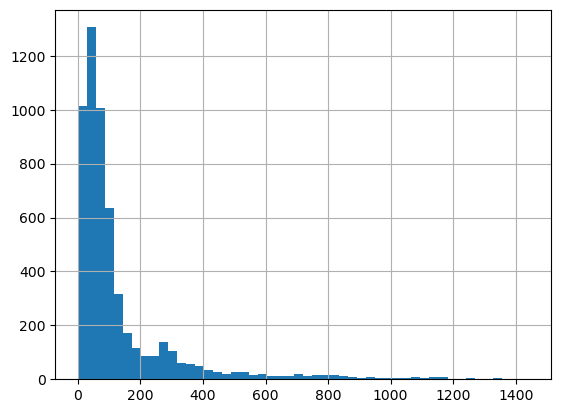

In [79]:
# Print best parameters
print('Best parameters:', grid.best_params_)

# Print best score
print('Best score:', grid.best_score_)

# Test the model
y_test_pred = grid.predict(X_test)

# Print RMSE on test set
print('RMSE:', mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False))

# Range of target variable
print('Range of target variable:', y_test.min(), y_test.max())

# SD of target variable
print('SD of target variable:', y_test.std())

# Plot histogram of target variable
y_test.hist(bins=50)
